In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [2]:
# global constants
Sv=1.e9 # m^3/sec

In [3]:
# stationary forcing 
input_data = np.load('data/input_sal_temp_ns.npy')[:, 1:]
output_data = np.load('data/output_sal_temp_ns.npy')

In [4]:
X_train = input_data[0:60000]
y_train = output_data[0:60000]
X_val = input_data[60000:80000]
y_val = output_data[60000:80000]
X_test = input_data[80000:100000]
y_test = output_data[80000:100000] 

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

# Y_train = keras.utils.to_categorical(y_train)
# Y_val = keras.utils.to_categorical(y_val)
# Y_test = keras.utils.to_categorical(y_test)
# output_scaled = keras.utils.to_categorical(output_data)

In [6]:
# used ChatGPT here 

import numpy as np

def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 10

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)


In [17]:
time_steps = 10  # Number of sequential vectors
feature_dim = 4  # Each vector has 5 features
batch_size = 32  # Batch size

model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid') 
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model_eval = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), 
          epochs=10, batch_size=batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.3201 - accuracy: 0.9677 - val_loss: 0.2311 - val_accuracy: 0.9999
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1377 - accuracy: 0.9996 - val_loss: 0.1194 - val_accuracy: 0.9998
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0743 - accuracy: 0.9997 - val_loss: 0.0647 - val_accuracy: 0.9997
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0412 - accuracy: 0.9997 - val_loss: 0.0355 - val_accuracy: 1.0000
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0233 - accuracy: 0.9997 - val_loss: 0.0200 - val_accuracy: 0.9999
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0134 - accuracy: 0.9997 - val_loss: 0.0113 - val_accuracy: 0.9999
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0079 - accuracy: 0.9997 - val_loss: 0.0064 - val_accuracy:

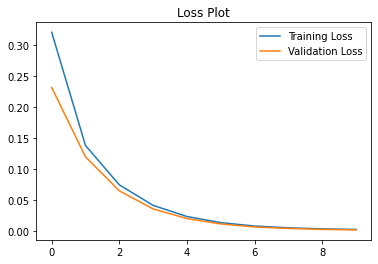

In [18]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [7]:
qplot = np.load('data/q_sal_temp_ns.npy')
time = np.load('data/input_sal_temp_ns.npy')[:, 0]

In [8]:
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [9]:
threshold = 0.5
predictions = (model.predict(input_seq) > threshold).astype(int)
false_indices = []
for j in range(len(predictions)):
    if predictions[j] != output_data[j]:
        false_indices.append(j)
plt.plot(time, qplot/Sv);
plt.plot(time, input_data[:, 0]*0,'k--');
plt.title('Incorrect Predictions for AMOC by LSTM');
plt.scatter([time[k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');

NameError: name 'model' is not defined

In [23]:
training_losses = np.zeros(10, dtype=np.ndarray)
validation_losses = np.zeros(10, dtype=np.ndarray)

In [25]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model_eval = model.fit(X_train_seq, y_train_seq,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    os.makedirs("models_lstm_ns", exist_ok=True)
    model.save('models_lstm_ns/ensemble_member_'+str(i)+'.keras')

0
1
2
3
4
5
6
Epoch 9: early stopping
7
Epoch 7: early stopping
8
9
Epoch 9: early stopping


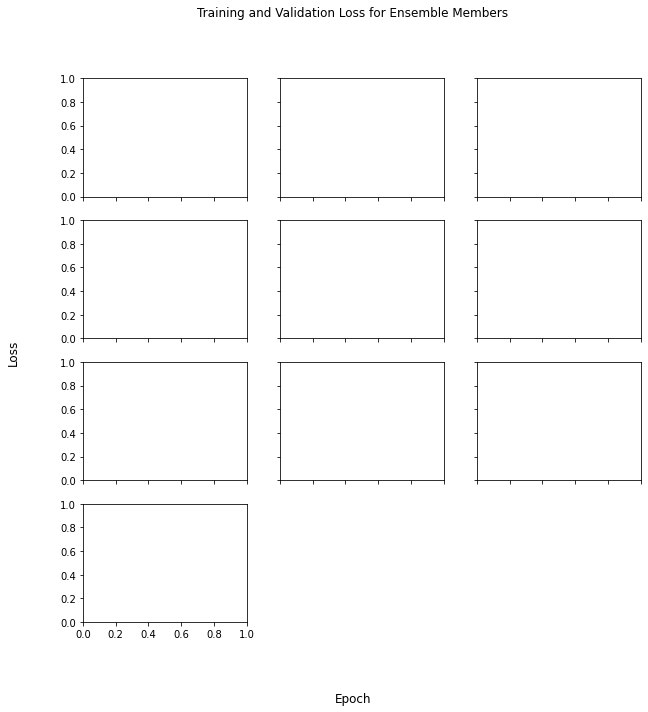

In [26]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members');
ax = ax.flatten();
for j in range(10, 12):  # 2 extra subplots in the 4x3 grid
    ax[j].axis('off');

In [27]:
np.save('training_loss', training_losses)

In [28]:
np.save('val_loss', validation_losses)

In [29]:
print(validation_losses)

[list([0.04113972932100296, 0.005101379472762346, 0.001773090218193829, 0.0009686718694865704, 0.0007780540618114173, 0.0008513942011632025, 0.00048211717512458563, 0.0005890640313737094, 0.0006572704296559095, 0.0005088803009130061])
 list([0.041396964341402054, 0.005389253608882427, 0.0017901386599987745, 0.001189239788800478, 0.0009539590100757778, 0.0007998329820111394, 0.0007524351240135729, 0.0007598269148729742, 0.0006294838385656476, 0.0005500644911080599])
 list([0.02344338968396187, 0.00319975009188056, 0.001230421825312078, 0.0007327001076191664, 0.0008462987025268376, 0.000651851762086153, 0.00048426754074171185, 0.0006313116173259914, 0.0005328980623744428, 0.0006318052764981985])
 list([0.041730381548404694, 0.005043890792876482, 0.0017010393785312772, 0.0010624363785609603, 0.0008218419970944524, 0.0007499681087210774, 0.0006494376575574279, 0.0005542139406315982, 0.00046170951100066304, 0.000498698849696666])
 list([0.00028845021734014153, 0.00027245021192356944, 0.0001

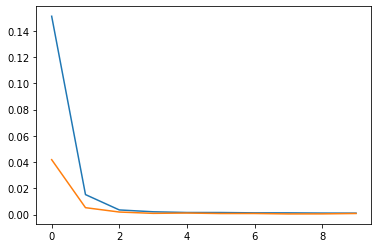

In [30]:
plt.plot(training_losses[8])
plt.plot(validation_losses[8])

In [31]:
for i in range(10):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member #' + str(i))

In [32]:
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2)  # fine-tune if needed
)

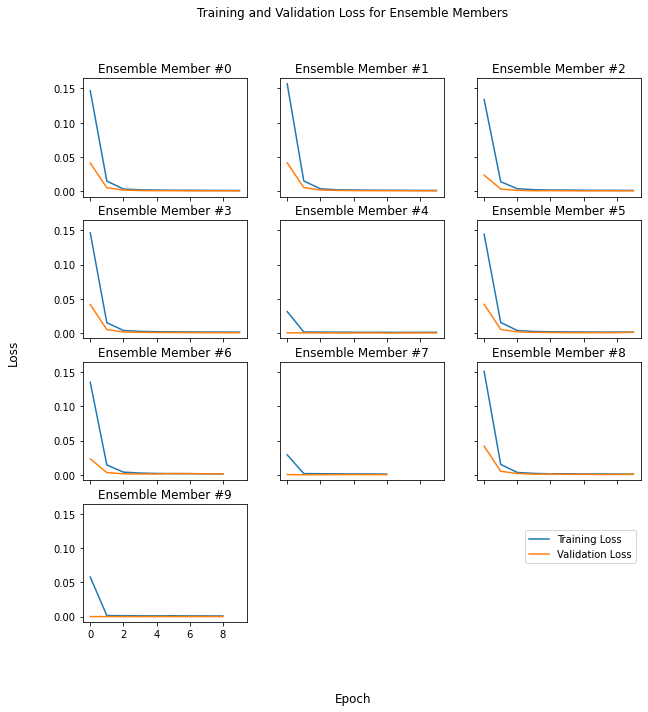

In [33]:
fig

In [34]:
fig.savefig('figures/lstm_losses_nonstationary', dpi=100)

In [35]:
accuracies = []

In [36]:
for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.load_weights('models_lstm_ns/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_seq, y_test_seq)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
625/625 [==============================] - 1s 1ms/step - loss: 3.3444e-04 - accuracy: 0.9999
Test loss: 0.0003344437282066792
Test accuracy: 0.9998999834060669
1
625/625 [==============================] - 1s 1ms/step - loss: 3.7781e-04 - accuracy: 0.9998
Test loss: 0.00037781306309625506
Test accuracy: 0.9998499155044556
2
625/625 [==============================] - 1s 1ms/step - loss: 7.7391e-04 - accuracy: 0.9998
Test loss: 0.0007739082793705165
Test accuracy: 0.9998499155044556
3
625/625 [==============================] - 1s 1ms/step - loss: 6.1287e-04 - accuracy: 0.9998
Test loss: 0.0006128736422397196
Test accuracy: 0.999799907207489
4
625/625 [==============================] - 1s 1ms/step - loss: 2.8804e-04 - accuracy: 0.9999
Test loss: 0.00028803720488213
Test accuracy: 0.9998999834060669
5
625/625 [==============================] - 1s 1ms/step - loss: 1.9237e-04 - accuracy: 0.9999
Test loss: 0.00019236686057411134
Test accuracy: 0.9999499917030334
6
625/625 [==================

In [37]:
sum(accuracies)/10*100

99.98599410057068

In [11]:
feature_dim=4

In [12]:
# predicting 

predicted_results_ensemble = np.nan * np.zeros((10, input_seq.shape[0], 1))

for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.load_weights('models_lstm_ns/ensemble_member_'+str(i)+'.keras')
    predicted = model.predict(input_seq)
    predicted_results_ensemble[i,...] = predicted

0
3125/3125 [==============================] - 4s 1ms/step
1
3125/3125 [==============================] - 4s 1ms/step
2
3125/3125 [==============================] - 4s 1ms/step
3
3125/3125 [==============================] - 4s 1ms/step
4
3125/3125 [==============================] - 4s 1ms/step
5
3125/3125 [==============================] - 5s 1ms/step
6
3125/3125 [==============================] - 5s 1ms/step
7
3125/3125 [==============================] - 5s 1ms/step
8
3125/3125 [==============================] - 4s 1ms/step
9
3125/3125 [==============================] - 4s 1ms/step


In [17]:
predicted_results_ensemble.shape

(10, 99991, 1)

In [13]:
avg_predicted = np.mean(predicted_results_ensemble, axis=0)

In [14]:
avg_predicted.shape

(99991, 1)

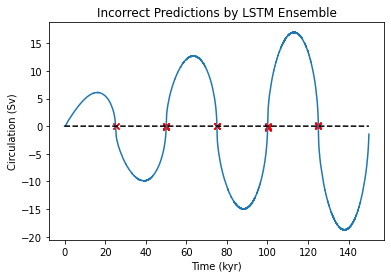

In [23]:
avg_predicted = np.mean(predicted_results_ensemble, axis=0).squeeze()
threshold = 0.5
avg_pred = (avg_predicted > threshold).astype(int)
false_indices_avg = [j for j in range(len(avg_pred)) if avg_pred[j] != output_data[j]]
fig, ax = plt.subplots()
ax.plot(time, qplot/Sv)
ax.plot(time, input_data[:, 0]*0, 'k--')
ax.set_title('Incorrect Predictions by LSTM Ensemble');
ax.set_xlabel('Time (kyr)');
ax.set_ylabel('Circulation (Sv)');
ax.scatter(
    [time[k] for k in false_indices_avg],
    [qplot[k]/Sv for k in false_indices_avg],
    marker='x', c='red', label='Errors'
)
fig.savefig('figures/lstm_predictions_ns_all', dpi=100)

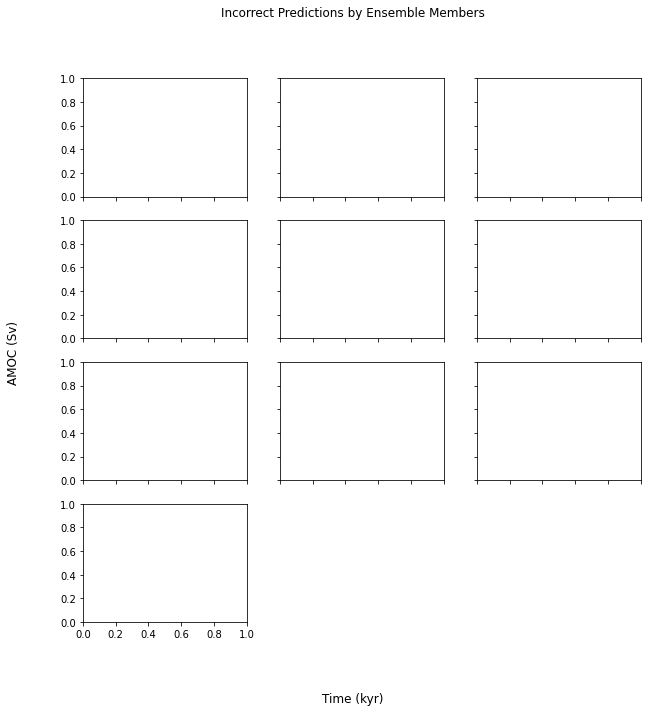

In [39]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by Ensemble Members')
ax = ax.flatten()
for j in range(10, 12):  # 2 extra subplots in the 4x3 grid
    ax[j].axis('off')

In [40]:
for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.load_weights('models_lstm_ns/ensemble_member_' + str(i) + '.keras')
    predictions_i = (model.predict(input_seq) > threshold).astype(int)
    false_indices_i = []
    for j in range(len(predictions_i)):
        if predictions_i[j] != output_data[j]:
            false_indices_i.append(j)
    ax[i].plot(time, qplot/Sv);
    ax[i].plot(time, input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member #' + str(i));
    ax[i].scatter([time[k] for k in false_indices_i], [qplot[i]/Sv for k in false_indices_i], marker='x', c='red');

0
3125/3125 [==============================] - 4s 1ms/step
1
3125/3125 [==============================] - 5s 2ms/step
2
3125/3125 [==============================] - 5s 2ms/step
3
3125/3125 [==============================] - 6s 2ms/step
4
3125/3125 [==============================] - 4s 1ms/step
5
3125/3125 [==============================] - 5s 1ms/step
6
3125/3125 [==============================] - 4s 1ms/step
7
3125/3125 [==============================] - 4s 1ms/step
8
3125/3125 [==============================] - 5s 1ms/step
9
3125/3125 [==============================] - 4s 1ms/step


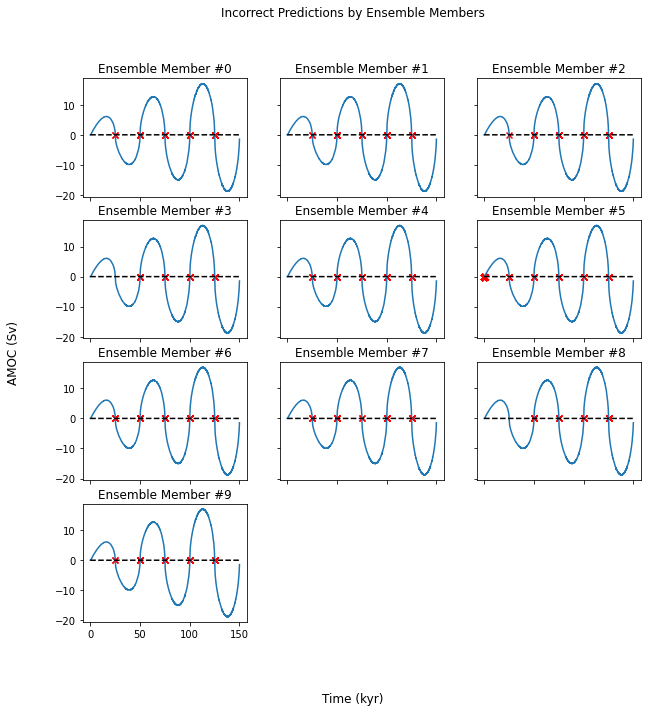

In [41]:
fig

In [42]:
fig.savefig('figures/lstm_predictions_nonstationary', dpi=100)

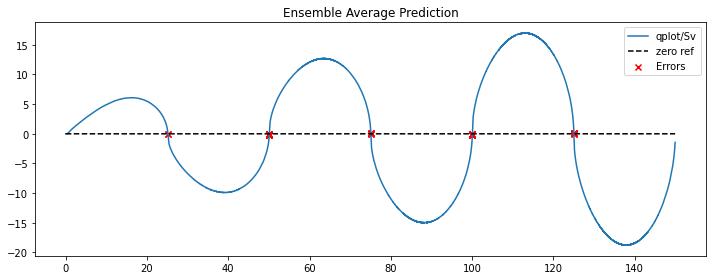

In [18]:
# Compute ensemble average
ensemble_avg = np.mean(predicted_results_ensemble, axis=0).squeeze()
ensemble_avg_binary = (ensemble_avg > threshold).astype(int)
false_indices_avg = [j for j in range(len(ensemble_avg_binary)) if ensemble_avg_binary[j] != output_data[j]]

# Plot ensemble average separately
plt.figure(figsize=(10, 4))
plt.plot(time, qplot/Sv, label='qplot/Sv')
plt.plot(time, input_data[:, 0]*0, 'k--', label='zero ref')
plt.title('Ensemble Average Prediction')
plt.scatter(
    [time[k] for k in false_indices_avg],
    [qplot[k]/Sv for k in false_indices_avg],
    marker='x', c='red', label='Errors'
)
plt.legend()
plt.tight_layout()
plt.show()
